# Bitcoin Price Analysis with Neural Network

This notebook performs a neural network analysis on the `hasil_atr_btc.csv` dataset to predict trading actions (Buy, Hold, Sell). The steps include:
1. Loading the dataset
2. Preprocessing (removing columns, handling duplicates, cleaning, and normalizing)
3. Exploratory Data Analysis (EDA)
4. Splitting data into training and testing sets
5. Designing and training a neural network
6. Testing and evaluating the model
7. Predicting on new data
8. Hyperparameter tuning with GridSearchCV

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier # Updated import path
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Load Dataset
Load the `hasil_atr_btc.csv` dataset using Pandas.

In [42]:
def load_and_prepare_data():
    # Assuming the dataset is available locally or via a function like loadFileData
    df = pd.read_csv('hasil_atr_btc.csv')  # Update path if needed
    return df

df = load_and_prepare_data()
df.head()

,Timestamp,Close,Open,Volume,Low,High,EMA200,MACD_Line,MACD_Line.1,Signal_Line,Histogram,RSI,SMA200,ATR,Type,Profit (%),Label
0,8/17/2017 17:00,4289.24,4354.18,59.664912,4235.45,4354.84,4318.265080,15.532265,15.532265,23.031451,-7.499186,47.800112,0.0,118.613333,Short,-0.84,Hold
1,8/18/2017 10:00,4356.31,4304.15,51.563675,4296.04,4371.52,4315.401412,-8.377528,-8.377528,-12.248853,3.871325,51.417988,0.0,66.086667,Long,-1.45,Hold
2,8/18/2017 14:00,4259.40,4293.09,74.368943,4193.70,4293.09,4315.023972,-8.678910,-8.678910,-8.471062,-0.207848,46.281014,0.0,87.523333,Short,2.84,Sell
3,8/19/2017 4:00,4068.26,4138.50,17.353232,4046.26,4156.00,4290.793888,-50.897604,-50.897604,-50.068578,-0.829026,35.472593,0.0,73.896667,Short,-0.66,Hold
4,8/20/2017 13:00,4063.35,4125.00,1.258162,4063.35,4125.00,4231.595239,4.322595,4.322595,5.814306,-1.491711,39.124017,0.0,56.496667,Short,-1.68,Hold


## 2. Preprocessing
- Remove columns: `Timestamp`, `Open`, `Low`, `High`
- Remove duplicate attributes (e.g., `MACD_Line`)
- Clean data by removing NaN rows
- Normalize numerical features
- Encode categorical variables (`Type` and `Label`)

In [41]:
def preprocess_data(df):
    # Remove specified columns
    df = df.drop(columns=['Timestamp', 'Open', 'Low', 'High'])

    # Remove duplicate MACD_Line column
    if 'MACD_Line.1' in df.columns:
        df = df.drop(columns=['MACD_Line.1'])

    # Clean data: remove rows with NaN
    df = df.dropna()

    # Separate features and target
    X = df.drop(columns=['Label'])
    y = df['Label']

    # Encode categorical variables
    le = LabelEncoder()
    X['Type'] = le.fit_transform(X['Type'])
    y = le.fit_transform(y)

    # Normalize numerical features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

    return X, y, scaler, le

X, y, scaler, le = preprocess_data(df)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (2308, 11)
Target shape: (2308,)


## 3. Exploratory Data Analysis (EDA)
- **Boxplot**: Detect outliers in numerical features
- **Pairplot**: Visualize relationships between numerical features
- **Heatmap**: Check correlations to identify redundant features

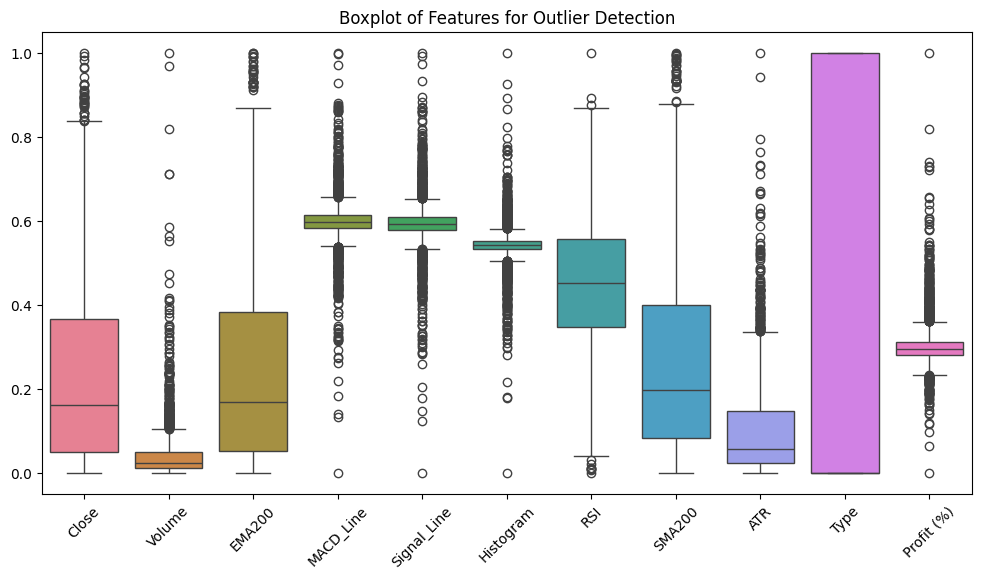

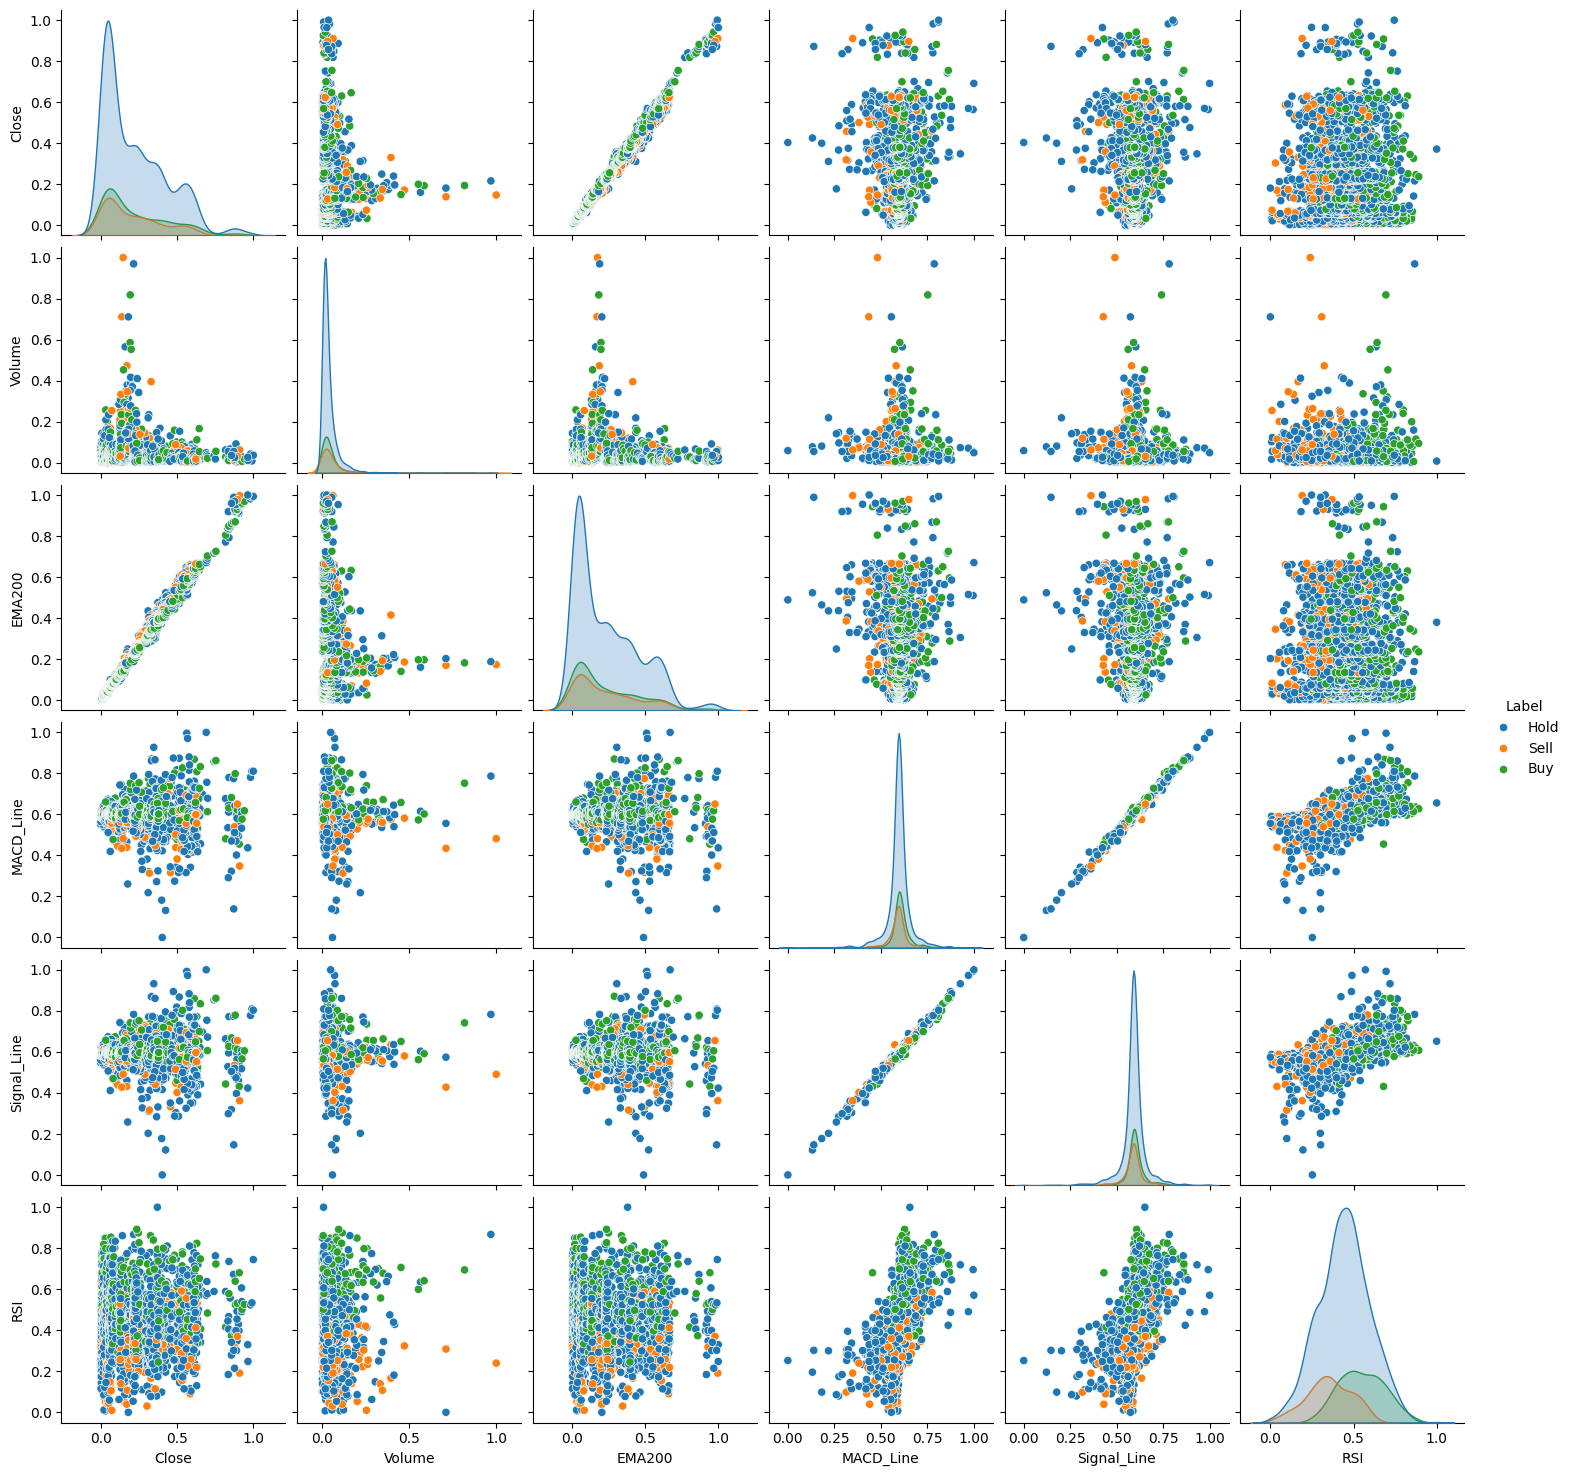

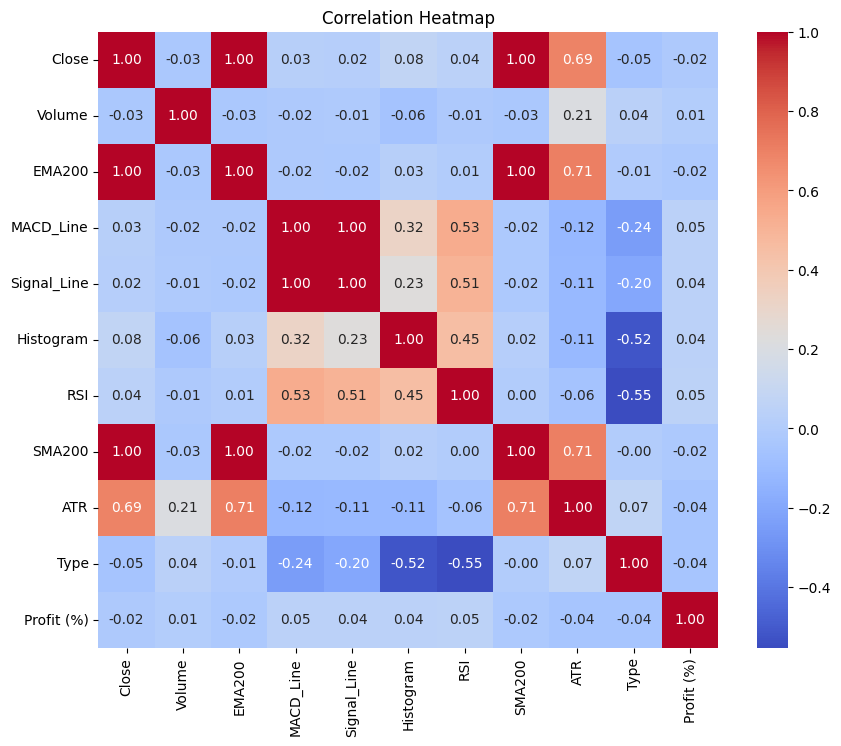

In [23]:
def perform_eda(X, y, le):
    # Create a temporary DataFrame for EDA
    df_eda = X.copy()
    df_eda['Label'] = le.inverse_transform(y)

    # Boxplot for outlier detection
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_eda.drop(columns=['Label']))
    plt.xticks(rotation=45)
    plt.title('Boxplot of Features for Outlier Detection')
    plt.savefig('boxplot.png')
    plt.show()
    plt.close()

    # Pairplot for feature relationships
    sns.pairplot(df_eda, hue='Label', vars=['Close', 'Volume', 'EMA200', 'MACD_Line', 'Signal_Line', 'RSI'])
    plt.savefig('pairplot.png')
    plt.show()
    plt.close()

    # Heatmap for correlation
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_eda.drop(columns=['Label']).corr(), annot=True, cmap='coolwarm', fmt='.2f') # Drop 'Label' for correlation
    plt.title('Correlation Heatmap')
    plt.savefig('heatmap.png')
    plt.show()
    plt.close()

perform_eda(X, y, le)

## 4. Split Data
Split the dataset into 80% training and 20% testing sets.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1846, 11)
Testing set shape: (462, 11)


## 5. Design Neural Network Model
Create a Keras Sequential model with two hidden layers, dropout for regularization, and a softmax output layer for three-class classification (Buy, Hold, Sell).

In [25]:
def create_model(neurons=64, learning_rate=0.001):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(neurons//2, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')  # 3 classes: Buy, Hold, Sell
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the model
model = create_model()
model.summary()

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_255 (Dense)               │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,947 (11.51 KB)

 Trainable params: 2,947 (11.51 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train Model
Train the neural network on the training data for 50 epochs.

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5691 - loss: 0.9726 - val_accuracy: 0.6838 - val_loss: 0.7604
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6737 - loss: 0.7704 - val_accuracy: 0.6838 - val_loss: 0.6898
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6628 - loss: 0.7205 - val_accuracy: 0.6838 - val_loss: 0.6557
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6768 - loss: 0.6745 - val_accuracy: 0.6838 - val_loss: 0.6401
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6880 - loss: 0.6483 - val_accuracy: 0.6838 - val_loss: 0.6340
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6765 - loss: 0.6495 - val_accuracy: 0.6838 - val_loss: 0.6191
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6779 - loss: 0.6336 - val_accuracy: 0.6838 - val_loss: 0.6092
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6811 - loss: 0.6296 - val_accuracy: 0.6838 - val_loss

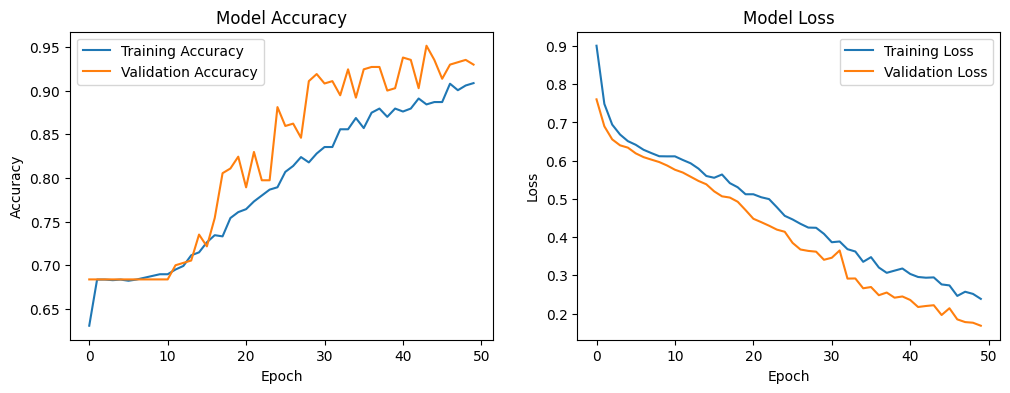

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Melatih model dan mendapatkan history (asumsi sudah dijalankan sebelumnya)
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluasi model pada data uji
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
report = classification_report(y_test, y_pred_classes, target_names=le.classes_, output_dict=True)

# Buat figure dengan 3 subplot: report di atas, accuracy dan loss di bawah
plt.figure(figsize=(12, 8))

# Subplot 1: Tampilkan report sebagai teks
plt.subplot(3, 1, 1)
report_text = (
    f"=== Hasil Evaluasi Model ===\n"
    f"Akurasi  : {accuracy:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall   : {recall:.4f}\n"
    f"F1-Score : {f1:.4f}\n\n"
    f"=== Classification Report ===\n"
    f"{'':5} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}\n"
    f"{0:5} {report[str(0)]['precision']:>10.2f} {report[str(0)]['recall']:>10.2f} {report[str(0)]['f1-score']:>10.2f} {report[str(0)]['support']:>10.0f}\n"
    f"{1:5} {report[str(1)]['precision']:>10.2f} {report[str(1)]['recall']:>10.2f} {report[str(1)]['f1-score']:>10.2f} {report[str(1)]['support']:>10.0f}\n"
    f"{2:5} {report[str(2)]['precision']:>10.2f} {report[str(2)]['recall']:>10.2f} {report[str(2)]['f1-score']:>10.2f} {report[str(2)]['support']:>10.0f}\n"
    f"{'accuracy':5} {report['accuracy']:>10.2f} {'':>10} {'':>10} {report['weighted avg']['support']:>10.0f}\n"
    f"{'macro avg':5} {report['macro avg']['precision']:>10.2f} {report['macro avg']['recall']:>10.2f} {report['macro avg']['f1-score']:>10.2f} {report['macro avg']['support']:>10.0f}\n"
    f"{'weighted avg':5} {report['weighted avg']['precision']:>10.2f} {report['weighted avg']['recall']:>10.2f} {report['weighted avg']['f1-score']:>10.2f} {report['weighted avg']['support']:>10.0f}"
)
plt.text(0.5, 0.5, report_text, ha='center', va='center', wrap=True, fontsize=8)
plt.axis('off')  # Sembunyikan sumbu untuk subplot teks

# Subplot 2: Accuracy
plt.subplot(3, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xlim(0, 50)

# Subplot 3: Loss
plt.subplot(3, 1, 3)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xlim(0, 50)

# Sesuaikan tata letak dan simpan
plt.tight_layout()
plt.savefig('training_history_with_report.png')
plt.show()
plt.close()

## 7. Test Model & 8. Evaluate Accuracy
Evaluate the model on the test set and print accuracy and classification report.

In [27]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9329004329004329

Classification Report:
              precision    recall  f1-score   support

         Buy       0.99      0.75      0.85        91
        Hold       0.91      1.00      0.95       319
        Sell       1.00      0.87      0.93        52

    accuracy                           0.93       462
   macro avg       0.97      0.87      0.91       462
weighted avg       0.94      0.93      0.93       462



## 9. Predict New Data
Demonstrate prediction on a sample test data point.

In [28]:
new_data = X_test.iloc[0:1].copy()  # Take one sample from test set
pred = model.predict(new_data)
pred_class = le.inverse_transform([np.argmax(pred, axis=1)[0]])[0]
print(f"Prediction for sample data: {pred_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction for sample data: Hold


## 10. Hyperparameter Tuning with GridSearchCV
Tune the number of neurons, learning rate, and batch size using GridSearchCV.

In [37]:
from tensorflow.keras.optimizers import Adam

# Define the model creation function with neurons and learning_rate as parameters
def create_model(neurons=32, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neurons // 2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))  # 3 classes: Buy, Hold, Sell
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

# Create KerasClassifier with additional parameters
model = KerasClassifier(model=create_model, epochs=50, verbose=0)

# Define the parameter grid
param_grid = {
    'model__neurons': [32, 64, 128],  # Prefix with 'model__' for scikeras
    'model__learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Print results
print("\nBest Parameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters: {'batch_size': 32, 'model__learning_rate': 0.01, 'model__neurons': 32}
Best Accuracy: 0.9626157040791187



=== Report Hasil GridSearchCV ===
Best Parameters: {'batch_size': 32, 'model__learning_rate': 0.01, 'model__neurons': 32}
Best Cross-Validation Accuracy: 0.9626

Detailed Results:
    neurons  learning_rate  batch_size  mean_accuracy
12       32          0.010          32       0.962616
13       64          0.010          32       0.955577
21       32          0.010          64       0.945848
22       64          0.010          64       0.945271
11      128          0.001          32       0.944734


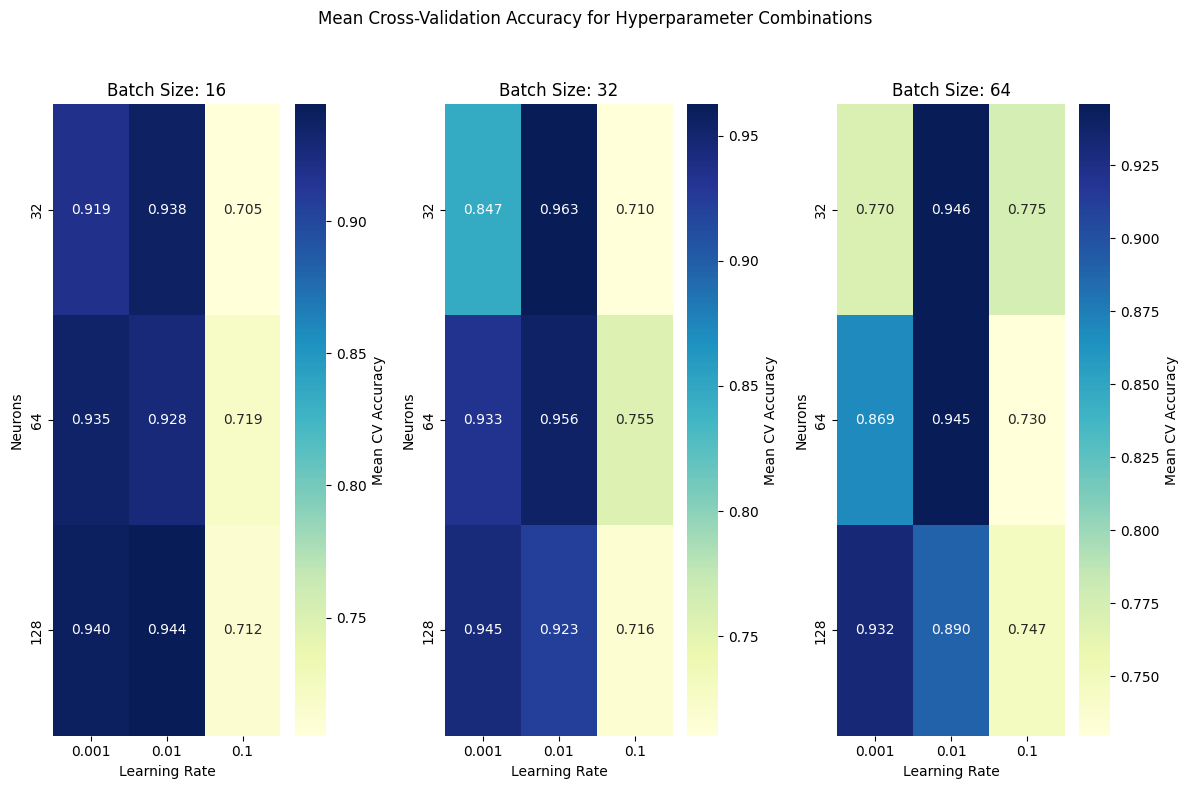

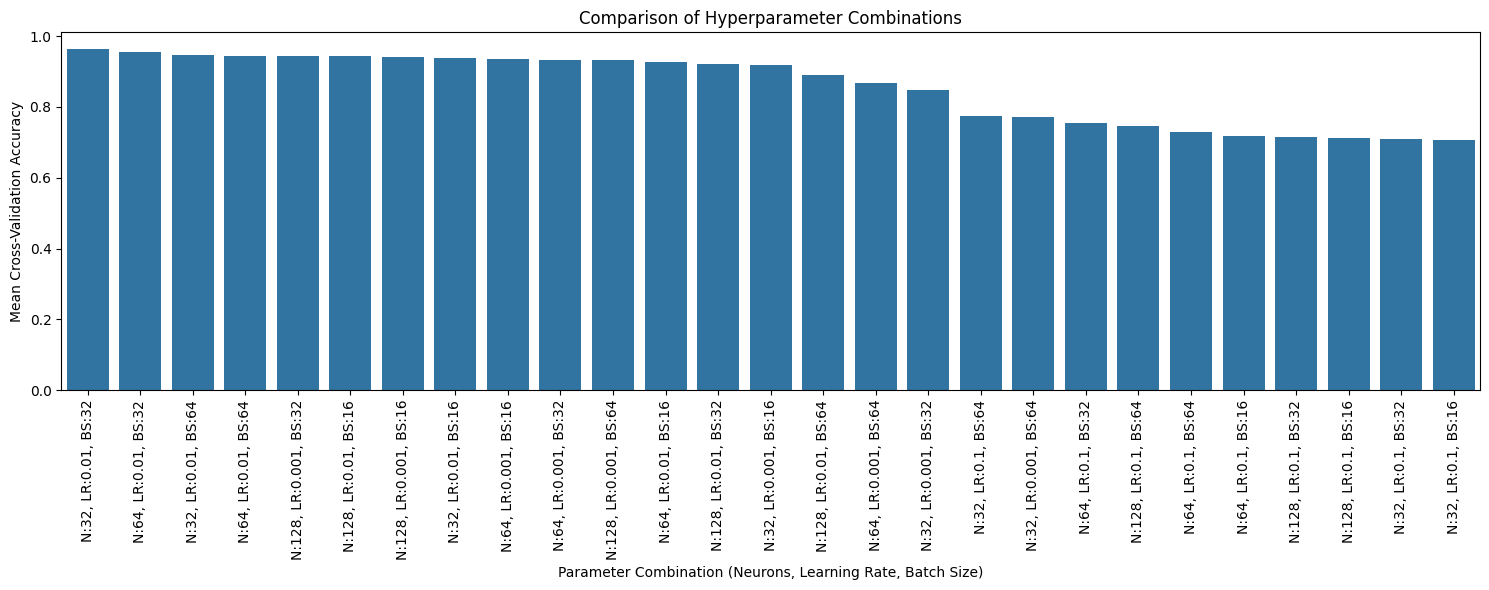

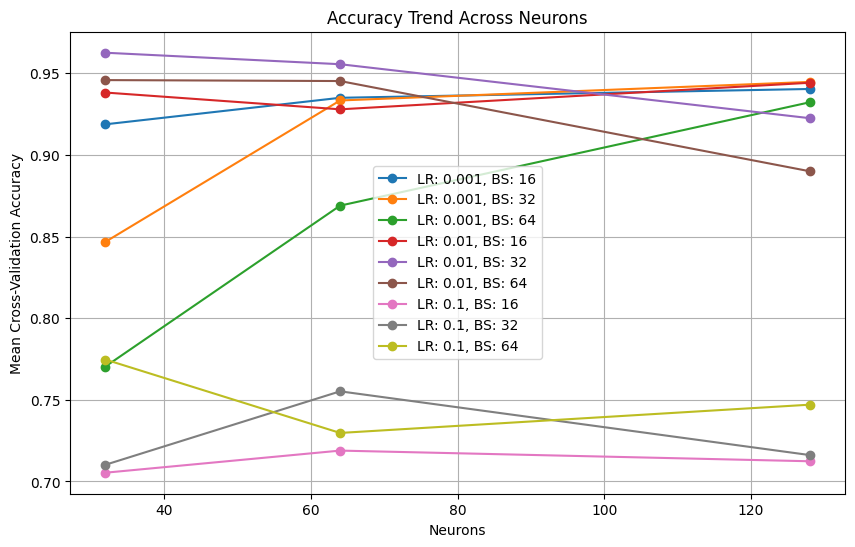

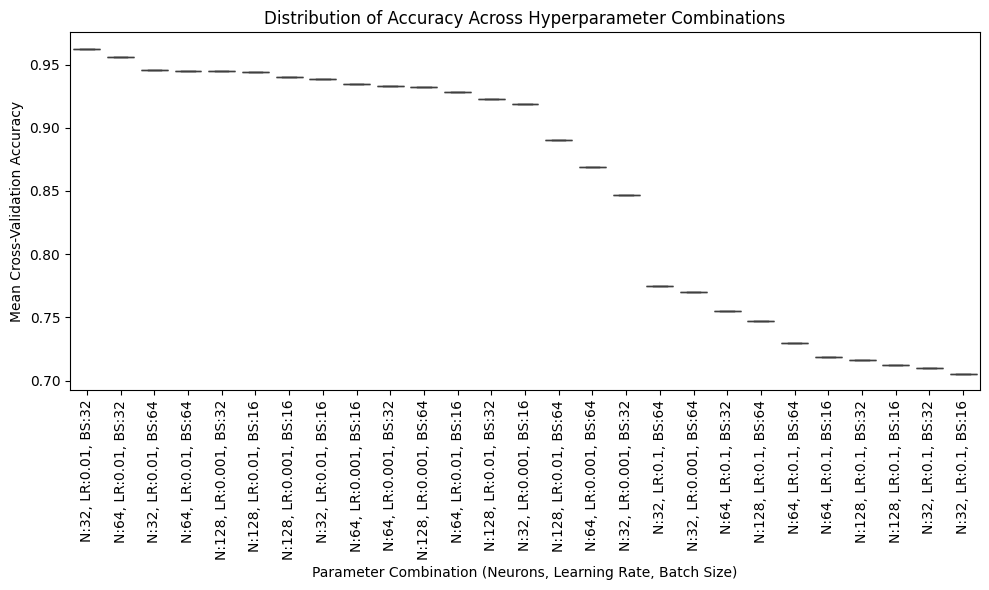

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ekstrak hasil GridSearchCV ke DataFrame
results = pd.DataFrame(grid_result.cv_results_)

# Buat kolom untuk parameter yang relevan
results['neurons'] = results['param_model__neurons'].astype(int)
results['learning_rate'] = results['param_model__learning_rate'].astype(float)
results['batch_size'] = results['param_batch_size'].astype(int)
results['mean_accuracy'] = results['mean_test_score']

# Report Hasil
print("\n=== Report Hasil GridSearchCV ===")
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_result.best_score_:.4f}")
print("\nDetailed Results:")
print(results[['neurons', 'learning_rate', 'batch_size', 'mean_accuracy']].sort_values('mean_accuracy', ascending=False).head())

# 1. Heatmap untuk neurons vs learning_rate (per batch_size)
plt.figure(figsize=(12, 8))
for batch_size in param_grid['batch_size']:
    subset = results[results['batch_size'] == batch_size]
    pivot = subset.pivot(index='neurons', columns='learning_rate', values='mean_accuracy')

    plt.subplot(1, len(param_grid['batch_size']), param_grid['batch_size'].index(batch_size) + 1)
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'Mean CV Accuracy'})
    plt.title(f'Batch Size: {batch_size}')
    plt.xlabel('Learning Rate')
    plt.ylabel('Neurons')

plt.suptitle('Mean Cross-Validation Accuracy for Hyperparameter Combinations')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('gridsearch_heatmap.png')
plt.show()
plt.close()

# 2. Bar Plot untuk semua kombinasi parameter
results['param_combo'] = results.apply(
    lambda x: f"N:{x['neurons']}, LR:{x['learning_rate']}, BS:{x['batch_size']}", axis=1
)
plt.figure(figsize=(15, 6))
sns.barplot(x='param_combo', y='mean_accuracy', data=results.sort_values('mean_accuracy', ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Parameter Combination (Neurons, Learning Rate, Batch Size)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Comparison of Hyperparameter Combinations')
plt.tight_layout()
plt.savefig('gridsearch_barplot.png')
plt.show()
plt.close()

# 3. Line Plot untuk tren akurasi berdasarkan neurons
plt.figure(figsize=(10, 6))
for lr in param_grid['model__learning_rate']:
    for bs in param_grid['batch_size']:
        subset = results[(results['learning_rate'] == lr) & (results['batch_size'] == bs)]
        plt.plot(subset['neurons'], subset['mean_accuracy'], marker='o', label=f'LR: {lr}, BS: {bs}')
plt.xlabel('Neurons')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Accuracy Trend Across Neurons')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_trend_neurons.png')
plt.show()
plt.close()

# 4. Box Plot untuk distribusi akurasi antar kombinasi
plt.figure(figsize=(10, 6))
sns.boxplot(x='param_combo', y='mean_accuracy', data=results.sort_values('mean_accuracy', ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Parameter Combination (Neurons, Learning Rate, Batch Size)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Distribution of Accuracy Across Hyperparameter Combinations')
plt.tight_layout()
plt.savefig('accuracy_boxplot.png')
plt.show()
plt.close()